# Interpret the results obtained from each of the experiments

The results from the experiments involve interpreting and plotting several quantities
- CPU Utilization of the slaves during the experiments
- IO Wait of the slaves during the experiments
- Accuracy of the final model after 10 epochs
- Response time of the model after 10 epochs

(Possible other result to see)
- Throughput of the model

In [1]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
from collections import defaultdict
import glob
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# For the ANOVA test
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols


## Extract from the log files the Accuracy and the Response Time

The files are in the folder from the master server, and we get a final line in the files with
the total wall clock time and the final accuracy

The folder structure taken into consideration is the following, from the root folder for the set
of experiments in question (2k or full) we get 4 folders, 1 for the master and 1 for each slave,
and inside these folders we get 1 folder for each of the replications. Inside we should find the
pickle files and the log files in case of the master


In [2]:
from typing import List, Dict


# Create some class to comfortably save the experiments and their results
class Experiment:
    def __init__(self, name: str):
        """Given the name of the experiment, extract the number of cpu's
        and so on"""
        self._name = name

        # Extract the cpu, batch and njobs by splitting
        parts = name.split('-')
        self.cpu = int(parts[0].replace('cpu', '').strip())
        self.batch = int(parts[1].replace('batch', '').strip())
        self.njobs = int(parts[2].replace('njobs', '').strip())
        self.network = str(parts[3].replace('network', '').strip())

    # Override the hash function so we can use it as
    # key of the dictionary
    def __hash__(self):
        return self._name

class ExperimentResults:

    def __init__(self, time: float, accuracies: List[float]):
        self.time = time
        self.accuracies = accuracies
        self.final_accuracy = accuracies[-1]


In [3]:

def split_name(exp_name: str) -> (int, int, int):
    """Given the name of the file give back the settings of the experiment"""
    parts = exp_name.split('-')
    cpu = int(parts[0].replace('cpu', '').strip())
    batch = int(parts[1].replace('batch', '').strip())
    njobs = int(parts[2].replace('njobs', '').strip())
    network = str(parts[3])[3:] if len(parts) > 3 else 'lenet'

    return cpu, batch, njobs, network

# Read the folder os the master and search for the accuracy to build the dictionary
# Right now for testing it just has one replication



# Get a dict ready to transform into a dataframe for training of the
# model and representation
results = {
    'exp_name': [],
    'replication': [],
    'cpu': [],
    'batch': [],
    'njobs': [],
    'network': [],
    'time': [],
    'accuracies':[],
    'final_accuracy': []
}
# Just take the final valuie for the ANOVA test
# res_final = defaultdict(dict)


replications = 2

for r in range(1, 1+replications):
    # This is the path we should change to either analyze the 2k or the full factorial
    path_root_master = f'./experiments/fullfact/master/{r}'
    
    # get the log files
    logs = glob.glob(os.path.join(path_root_master, '*.log'))
    
    
    print(f'Extracting the data from {len(logs)} files')
    for log in logs:
        acc = []
        with open(log, 'r') as f:
            for line in f:
                if 'Top1Accuracy is Accuracy' in line:
                    try:
                        _accuracy = line.strip().split(']')[-1].split(',')[-1].split(':')[-1].replace(')', '')
                        acc.append(float(_accuracy.strip()))
                    except Exception as e:
                        print('Error while reading accuracy',e)
                    if len(acc) == 10:
                        # Then save the time here
                        time = float(line.strip().split(']')[-2].split('[')[-1].split(' ')[-1].replace('s', ''))
                        break
        # Add the results to the dictionary
        variables = log.split('-')[1:]
        if len(variables) < 4:
            variables[-1] = variables[-1].split('.')[0]
            variables.append('netlenet5')
        name = '-'.join(variables).replace('.log', '')
        cpu, batch, njobs , network= split_name(name)
        # set all the columns
        results['cpu'].append(cpu)
        results['batch'].append(batch)
        results['njobs'].append(njobs)
        results['network'].append(network)
        results['accuracies'].append(acc)
        results['time'].append(time)
        results['final_accuracy'].append(acc[-1])
        results['exp_name'].append(name)
        results['replication'].append(r)


results_df = pd.DataFrame(results)
# results_df = results_df.set_index('exp_name')

# We should get the last accuracy to run ANOVA but to plot this is better
results_df


Extracting the data from 96 files
Error while reading accuracy could not convert string to float: 'validate model throughput is 23402.63 records/second'
Error while reading accuracy could not convert string to float: 'Save model to /tmp/simplenet/20201021_135727'
Extracting the data from 96 files
Error while reading accuracy could not convert string to float: 'validate model throughput is 22114.438 records/second'
Error while reading accuracy could not convert string to float: 'Save model to /tmp/lenet5/20201021_182017'
Error while reading accuracy could not convert string to float: 'Save model to /tmp/lenet5/20201021_182354'
Error while reading accuracy could not convert string to float: 'Current learning rate is 0.008931761343336907. Current dampening is 1.7976931348623157E308.'
Error while reading accuracy could not convert string to float: 'Current learning rate is 0.008406186953597848. Current dampening is 1.7976931348623157E308.'


,exp_name,replication,cpu,batch,njobs,network,time,accuracies,final_accuracy
0,cpu1-batch64-njobs1-netlenet5,1,1,64,1,lenet5,493.510662,"[0.8841, 0.9189, 0.9298, 0.9374, 0.9421, 0.946...",0.9567
1,cpu2-batch64-njobs1-netlenet5,1,2,64,1,lenet5,477.422871,"[0.8794, 0.9127, 0.927, 0.9359, 0.9412, 0.9469...",0.9580
2,cpu4-batch256-njobs1-netlenet5,1,4,256,1,lenet5,153.519246,"[0.6808, 0.8058, 0.8565, 0.8815, 0.8948, 0.906...",0.9288
3,cpu8-batch256-njobs1-netlenet5,1,8,256,1,lenet5,153.905961,"[0.6872, 0.7999, 0.8486, 0.8739, 0.8889, 0.9, ...",0.9213
4,cpu1-batch512-njobs1-netlenet5,1,1,512,1,lenet5,179.730715,"[0.5992, 0.7516, 0.7949, 0.8287, 0.8485, 0.864...",0.8957
...,...,...,...,...,...,...,...,...,...
187,cpu8-batch256-njobs5-netsimplenet,2,8,256,5,simplenet,191.543720,"[0.9019, 0.9082, 0.9132, 0.9158, 0.92, 0.9228,...",0.9274
188,cpu1-batch512-njobs5-netsimplenet,2,1,512,5,simplenet,102.833203,"[0.815, 0.871, 0.8873, 0.896, 0.9002, 0.9051, ...",0.9163
189,cpu2-batch512-njobs5-netsimplenet,2,2,512,5,simplenet,101.472417,"[0.8178, 0.8704, 0.8856, 0.8959, 0.8994, 0.904...",0.9139
190,cpu4-batch512-njobs5-netsimplenet,2,4,512,5,simplenet,107.606112,"[0.8259, 0.8711, 0.8873, 0.8939, 0.8993, 0.902...",0.9131


In [4]:
results_df.groupby('network').mean()

,replication,cpu,batch,njobs,time,final_accuracy
network,,,,,,
lenet5,1.5,3.75,240.0,3.0,311.826275,0.930344
simplenet,1.5,3.75,240.0,3.0,277.713189,0.931964


# Extract the CPU and IO wait from the pickle files

In this case we need the slave folders (we will check that the folder contains the word slave to analyze the files)
and we will extract the pickle files from where we will get the CPU load and the IO wait percentage

There is a thing to take in mind. The experiment runs for a default of 5 minutes, so if the experiment lasted
less than 300 seconds, which we can get from the results dictionary from before, we should trim the vectors taking
into account that each measurement is taken every 2 seconds so it just comprises that experiment and doesn't
introduce noise from the next

In [16]:
def coalesce_metrics(loads, threshold = 1):
    """We have three slaves, and sometimes not all of them are working
    if the numnber of cpus and jobs is just one

    In these cases,  discard the lists with an average too close to zero,
    if not, add the slaves together and calculate the mean at each point to
    get the final vector."

    :param: threshold: the threshold of utilization under which we conside
                        that the server was not used in the experiment"""
    # Dict to build the dataframe
    avg_loads = {
        'exp_name': [],
        'replication': [],
        'cpu_load': [],
        'iowait': [],
        'cpu_mean': [],
        'iowait_mean':[]
    }

    for exp, dict1 in loads.items():
        for slaves, dict2 in dict1.items():
            for rep, metrics in dict2.items():
                # print(f'\n{exp}')
                count = 0
                list_length = len(list(metrics.values())[0])
                c = np.zeros(list_length)
                io = np.zeros(list_length)
                # for slave, metrics in slaves.items():
        
                # if the mean is too slow discard
                cpu_mean = np.mean(metrics['cpu'])
                if  cpu_mean <threshold:
                    # print(f'Discarding {slave} with cpu mean =',cpu_mean)
                    pass
                else:
                    c += metrics['cpu']
                    io += metrics['iowait']
                    count += 1
                    # print(slave, np.mean(metrics['cpu']), np.mean(metrics['iowait']))
                    # print(metrics['cpu'])
        
                # print('dividing by ',count)
                avg_loads['exp_name'].append(exp)
                avg_loads['replication'].append(rep)
                avg_loads['cpu_load'].append(c / count)
                avg_loads['iowait'].append(io/count)
                avg_loads['cpu_mean'].append(np.mean(c/count))
                avg_loads['iowait_mean'].append(np.mean(io/count))
        
        
                # avg_loads[exp] = {
                #     'cpu': c / count,
                #     'iowait': io/count,
                #     'cpu_mean': np.mean(c/count),
                #     'iowait_mean':np.mean(io/count)
                # }

    return avg_loads

In [18]:
root_folder_slaves = './experiments/fullfact/'

dirs = os.listdir(root_folder_slaves)
# slave_dirs = [f for f in dirs if 'slave' in f]
slave_dirs = ['slave1', 'slave2']

def rec_dd():
    return defaultdict(rec_dd)

loads = rec_dd()
# The shape of the results is
# name of the file:
#     - slave 1:
#         - cpu: list
#         - iowait: list
#     - slave 2:
#         ...

# Do the same in all the folders
for folder in slave_dirs:
    for r in range(1, 1+replications):
        print('Processing files for the', folder)
        # get just the pickle files
        files = glob.glob(os.path.join(root_folder_slaves, folder, str(r),'*.pkl'))
    
        # Extract the dictionary from each file
        for f in files:
    
            # Get the name of the experiment to index the other dict
            variables = f.split('-')[1:]
            if len(variables) < 4:
                variables[-1] = variables[-1].split('.')[0]
                variables.append('netlenet5')
            exp_name = '-'.join(variables).replace('.pkl', '')
            # print(exp_name)
    
            with open(f, 'rb') as pickle_file:
                metrics = pickle.load(pickle_file)
    
            # Now we need to check to just get the metrics concerning the experiment
            # And not the following. We leave a margin of 10 seconds or 5 list positions just in case
            # to not cut too tightly
            exp_length = results_df.loc[(results_df.exp_name == exp_name) & (results_df.replication == r), 'time'].array[0]
            if exp_length > 300:
                loads[exp_name][folder][r] = metrics
    
            else:
                max_list_length = math.ceil(exp_length/2) + 5
                # print(f'Exp length was {exp_length}, so max list positions are {max_list_length}')
                if max_list_length < len(metrics['cpu']):
                    loads[exp_name][folder][r] = dict()
                    loads[exp_name][folder][r]['cpu'] = metrics['cpu'][:max_list_length]
                    loads[exp_name][folder][r]['iowait'] = metrics['iowait'][:max_list_length]
                else:
                    # Add the whole of it
                    loads[exp_name][folder][r] = metrics

# Get the average usage of the experiments
# The resulting dict will just map each
# pf the experiments to its avg cpu load and
# iowait across all slaves

avg_loads = coalesce_metrics(loads)
loads_df = pd.DataFrame(avg_loads)
loads_df

Processing files for the slave1
Processing files for the slave1
Processing files for the slave2
Processing files for the slave2


C:\Users\Tomek\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Tomek\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Tomek\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Tomek\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


,exp_name,replication,cpu_load,iowait,cpu_mean,iowait_mean
0,cpu1-batch64-njobs1-netlenet5,1,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN
1,cpu1-batch64-njobs1-netlenet5,2,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN
2,cpu1-batch64-njobs1-netlenet5,1,"[0.0, 0.0, 0.1, 0.0, 0.0, 3.2, 9.9, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.2, 0.8, 0.0, 0.0, ...",3.802667,0.170000
3,cpu1-batch64-njobs1-netlenet5,2,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN
4,cpu2-batch64-njobs1-netlenet5,1,"[0.0, 0.0, 0.0, 0.6, 9.7, 1.5, 3.6, 4.7, 1.2, ...","[0.0, 0.0, 0.0, 0.3, 1.0, 0.0, 0.4, 3.4, 2.9, ...",2.906000,0.100667
...,...,...,...,...,...,...
379,cpu4-batch512-njobs5-netsimplenet,2,"[0.0, 0.0, 0.0, 15.2, 12.6, 29.5, 32.7, 22.3, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.9, 3.2, 11.2,...",24.732203,1.649153
380,cpu8-batch512-njobs5-netsimplenet,1,"[0.0, 0.1, 0.0, 0.1, 14.3, 78.9, 94.7, 62.6, 1...","[0.0, 0.0, 0.1, 0.0, 0.0, 0.1, 0.0, 0.0, 9.9, ...",38.354545,10.074026
381,cpu8-batch512-njobs5-netsimplenet,2,"[50.0, 0.0, 0.0, 0.0, 27.2, 51.5, 75.5, 59.2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.1,...",37.947297,16.513514
382,cpu8-batch512-njobs5-netsimplenet,1,"[0.0, 0.1, 0.0, 0.5, 54.7, 95.2, 91.5, 34.7, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8, 20.2,...",41.559740,11.312987


### Merge the dataframes together so we get a common dataframe for all results


In [19]:
# Merge the two dataframes so we get all the data grouped by experiment number
results_df = results_df.merge(loads_df, on=['exp_name', 'replication'])

results_df

,exp_name,replication,cpu,batch,njobs,network,time,accuracies,final_accuracy,cpu_load,iowait,cpu_mean,iowait_mean
0,cpu1-batch64-njobs1-netlenet5,1,1,64,1,lenet5,493.510662,"[0.8841, 0.9189, 0.9298, 0.9374, 0.9421, 0.946...",0.9567,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN
1,cpu1-batch64-njobs1-netlenet5,1,1,64,1,lenet5,493.510662,"[0.8841, 0.9189, 0.9298, 0.9374, 0.9421, 0.946...",0.9567,"[0.0, 0.0, 0.1, 0.0, 0.0, 3.2, 9.9, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.2, 0.8, 0.0, 0.0, ...",3.802667,0.170000
2,cpu2-batch64-njobs1-netlenet5,1,2,64,1,lenet5,477.422871,"[0.8794, 0.9127, 0.927, 0.9359, 0.9412, 0.9469...",0.9580,"[0.0, 0.0, 0.0, 0.6, 9.7, 1.5, 3.6, 4.7, 1.2, ...","[0.0, 0.0, 0.0, 0.3, 1.0, 0.0, 0.4, 3.4, 2.9, ...",2.906000,0.100667
3,cpu2-batch64-njobs1-netlenet5,1,2,64,1,lenet5,477.422871,"[0.8794, 0.9127, 0.927, 0.9359, 0.9412, 0.9469...",0.9580,"[0.0, 0.0, 0.0, 10.5, 2.4, 0.0, 7.3, 10.5, 14....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.7, 2.6, 0.0, ...",3.475333,0.056000
4,cpu4-batch256-njobs1-netlenet5,1,4,256,1,lenet5,153.519246,"[0.6808, 0.8058, 0.8565, 0.8815, 0.8948, 0.906...",0.9288,"[0.0, 0.0, 0.1, 3.5, 7.1, 0.1, 4.3, 6.7, 15.5,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.7, 0.7, 0.0, ...",3.790244,0.071951
...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,cpu2-batch512-njobs5-netsimplenet,2,2,512,5,simplenet,101.472417,"[0.8178, 0.8704, 0.8856, 0.8959, 0.8994, 0.904...",0.9139,"[0.0, 0.0, 0.0, 0.0, 8.6, 15.3, 8.3, 14.5, 12....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 4.4, ...",12.828571,0.455357
380,cpu4-batch512-njobs5-netsimplenet,2,4,512,5,simplenet,107.606112,"[0.8259, 0.8711, 0.8873, 0.8939, 0.8993, 0.902...",0.9131,"[0.0, 0.0, 0.0, 9.8, 23.4, 10.7, 31.5, 25.4, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.2, 6.4,...",25.367797,2.498305
381,cpu4-batch512-njobs5-netsimplenet,2,4,512,5,simplenet,107.606112,"[0.8259, 0.8711, 0.8873, 0.8939, 0.8993, 0.902...",0.9131,"[0.0, 0.0, 0.0, 15.2, 12.6, 29.5, 32.7, 22.3, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.9, 3.2, 11.2,...",24.732203,1.649153
382,cpu8-batch512-njobs5-netsimplenet,2,8,512,5,simplenet,136.710108,"[0.8299, 0.8706, 0.888, 0.8925, 0.898, 0.9045,...",0.9152,"[50.0, 0.0, 0.0, 0.0, 27.2, 51.5, 75.5, 59.2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.1,...",37.947297,16.513514


## Plot the loads for each of the slaves for each of the experiments

In some experiments some of the slaves have zero load cause they are not used, in those cases
we should filter out the lists whose average is too close to zero. In other cases, we can just average the
load among all of the slaves.

### See the relationship with time

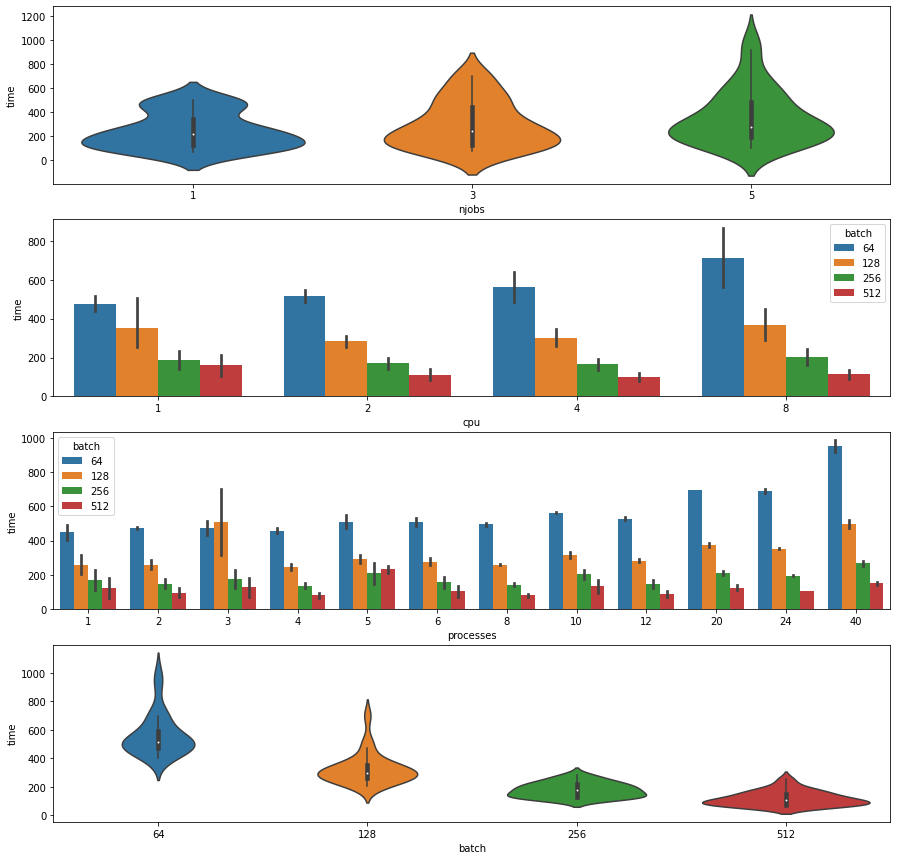

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

sns.violinplot(x='njobs', y='time', data=results_df, ax=ax1)
sns.barplot(x='cpu', y='time', hue='batch', data=results_df, ax=ax2)

results_df['processes'] = results_df['cpu'] * results_df['njobs']
sns.barplot(x='processes', y='time', hue='batch',data=results_df, ax=ax3)
sns.violinplot(x='batch', y='time', data=results_df, ax=ax4);


### See the relationships with the accuracy


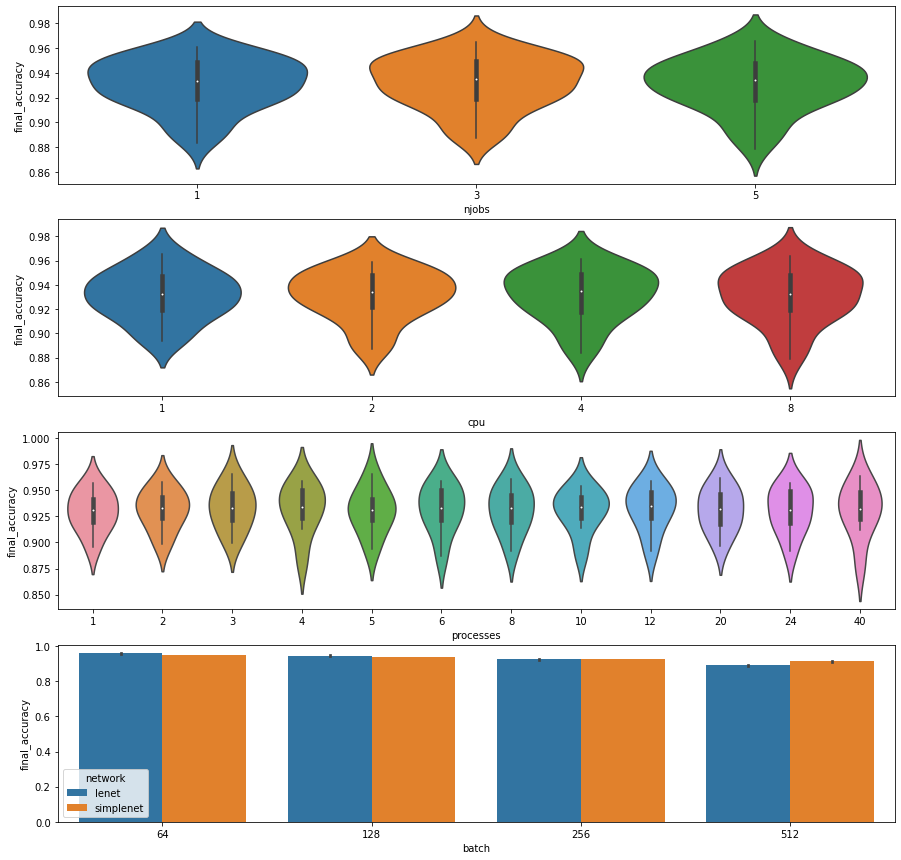

In [9]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

sns.violinplot(x='njobs', y='final_accuracy', data=results_df, ax=ax1)
sns.violinplot(x='cpu', y='final_accuracy', data=results_df, ax=ax2)

results_df['processes'] = results_df['cpu'] * results_df['njobs']
sns.violinplot(x='processes', y='final_accuracy', data=results_df, ax=ax3)
sns.barplot(x='batch', y='final_accuracy', hue='network', data=results_df, ax=ax4);


### See the relationship with the cpu load and iowait

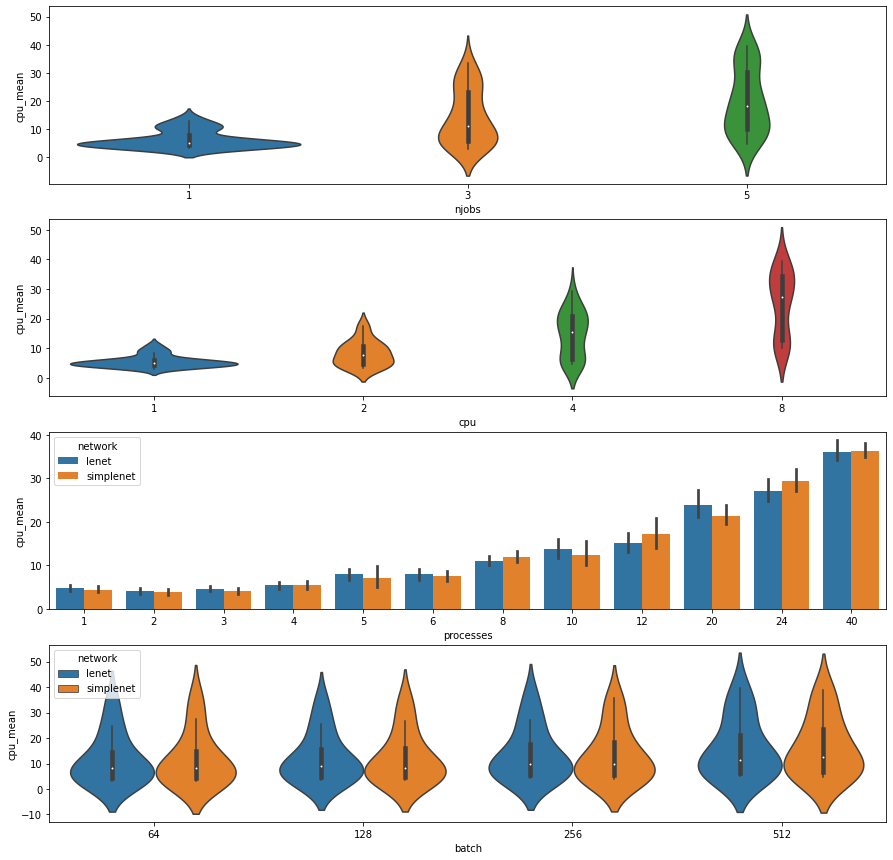

In [20]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

sns.violinplot(x='njobs', y='cpu_mean', data=results_df, ax=ax1)
sns.violinplot(x='cpu', y='cpu_mean', data=results_df, ax=ax2)

results_df['processes'] = results_df['cpu'] * results_df['njobs']
sns.barplot(x='processes', y='cpu_mean', hue='network', data=results_df, ax=ax3)
sns.violinplot(x='batch', y='cpu_mean', hue = 'network', data=results_df, ax=ax4);


# Surprisingly, the batch size doesn't influence cpu utilization??
serv_df = results_df.groupby(['batch', 'njobs']).mean()

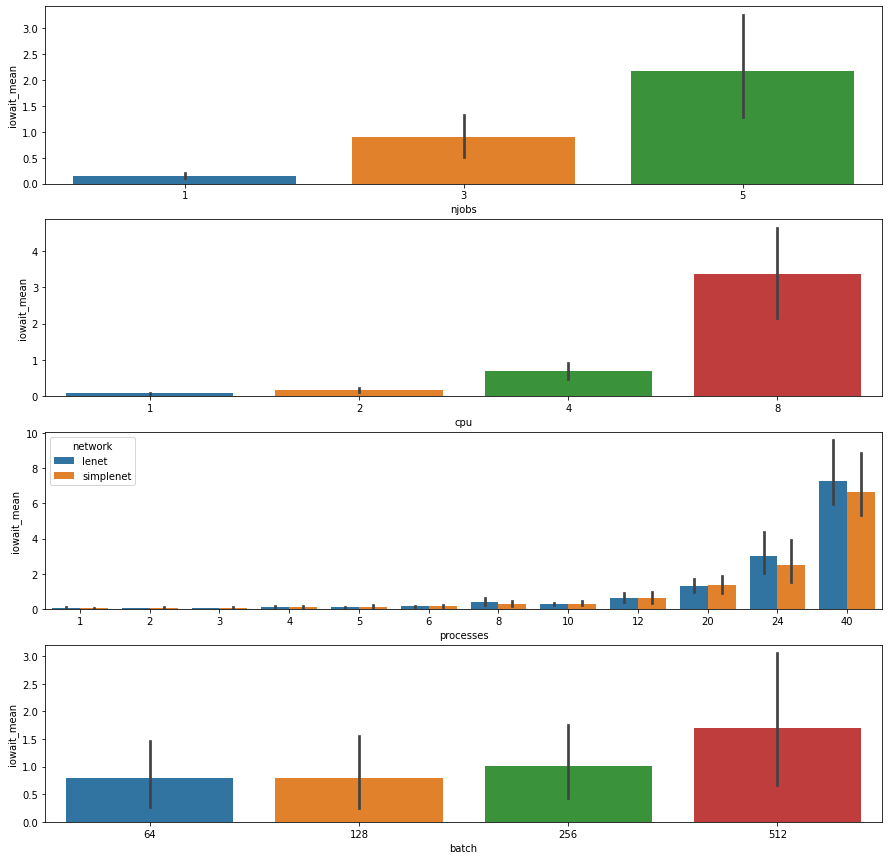

In [11]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

sns.barplot(x='njobs', y='iowait_mean', data=results_df, ax=ax1)
sns.barplot(x='cpu', y='iowait_mean', data=results_df, ax=ax2)

results_df['processes'] = results_df['cpu'] * results_df['njobs']
sns.barplot(x='processes', y='iowait_mean', hue='network', data=results_df, ax=ax3)
sns.barplot(x='batch', y='iowait_mean', data=results_df, ax=ax4);

## Run some statistical tests to see if the batch influences any of the outputs

In [15]:
# run for batch with the IO, CPU...

from scipy.stats import mannwhitneyu
import itertools

def njobs_significance_test(column: str):

    print('Starting jobs significance test for column', column)

    # Divide in batches
    n0 = results_df[results_df.njobs == 1][column]
    n1 = results_df[results_df.njobs == 3][column]
    n2 = results_df[results_df.njobs == 5][column]

    jobs = {1: n0,
               3:n1,
               5:n2
    }

    # Calculate p-values
    combinations = itertools.combinations(list(jobs.keys()), 2)
    for i, j in combinations:
        # Calculate the test for those two values
        _, p_val = mannwhitneyu(jobs[i], jobs[j])
        print(f'P-value of {i} and {j} is {p_val} --> {"RELEVANT" if p_val < 0.05 else "NON_RELEVANT"}')
    print()

def cpu_significance_test(column: str):

    print('Starting cpu significance test for column', column)

    # Divide in batches
    c0 = results_df[results_df.cpu == 1][column]
    c1 = results_df[results_df.cpu == 2][column]
    c2 = results_df[results_df.cpu == 4][column]
    c3 = results_df[results_df.cpu == 8][column]

    cpus = {1: c0,
               2:c1,
               4:c2,
               8:c3
    }

    # Calculate p-values
    combinations = itertools.combinations(list(cpus.keys()), 2)
    for i, j in combinations:
        # Calculate the test for those two values
        _, p_val = mannwhitneyu(cpus[i], cpus[j])
        print(f'P-value of {i} and {j} is {p_val} --> {"RELEVANT" if p_val < 0.05 else "NON_RELEVANT"}')
    print()


def batch_significance_test(column: str):

    print('Starting batch significance test for column', column)

    # Divide in batches
    b0 = results_df[results_df.batch == 64][column]
    b1 = results_df[results_df.batch == 128][column]
    b2 = results_df[results_df.batch == 256][column]
    b3 = results_df[results_df.batch == 512][column]

    batches = {64: b0,
               128:b1,
               256:b2,
               512:b3
    }

    # Calculate p-values
    combinations = itertools.combinations([64,128,256,512], 2)
    for i, j in combinations:
        # Calculate the test for those two values
        _, p_val = mannwhitneyu(batches[i], batches[j])
        print(f'P-value of {i} and {j} is {p_val} --> {"RELEVANT" if p_val < 0.05 else "NON_RELEVANT"}')
    print()

for col in ['time', 'final_accuracy', 'cpu_mean', 'iowait_mean']:
    print(f'--------- {col.upper()} ------------')
    batch_significance_test(col)
    njobs_significance_test(col)
    cpu_significance_test(col)

--------- TIME ------------
Starting batch significance test for column time
P-value of 64 and 128 is 1.2677958766051596e-07 --> RELEVANT
P-value of 64 and 256 is 1.5258408287505792e-09 --> RELEVANT
P-value of 64 and 512 is 1.5243462714137668e-09 --> RELEVANT
P-value of 128 and 256 is 3.8933481497524654e-08 --> RELEVANT
P-value of 128 and 512 is 2.510648038061492e-09 --> RELEVANT
P-value of 256 and 512 is 0.00010259273711841342 --> RELEVANT

Starting jobs significance test for column time
P-value of 1 and 3 is 0.13395962545866563 --> NON_RELEVANT
P-value of 1 and 5 is 0.011425140606952615 --> RELEVANT
P-value of 3 and 5 is 0.10463106018059959 --> NON_RELEVANT

Starting cpu significance test for column time
P-value of 1 and 2 is 0.2783695249891529 --> NON_RELEVANT
P-value of 1 and 4 is 0.2513730934210644 --> NON_RELEVANT
P-value of 1 and 8 is 0.40627452724409946 --> NON_RELEVANT
P-value of 2 and 4 is 0.4385463432859047 --> NON_RELEVANT
P-value of 2 and 8 is 0.21363945308598808 --> NON_R

## Try to calculate the service rate of the disk based on the number of jobs and the batch

In [43]:
Tcpu = 0.045
mu_cpu = 1/Tcpu
num_examples = 60000
num_epochs = 10


mus = {
    'batch':[],
    'njobs':[],
    'mu':[]
}

for (batch, njobs) , row in serv_df.iterrows():
    # Calculate the new numbers
    l_disk = njobs * mu_cpu
    T = row.time
    Nt = (num_examples/batch) * num_epochs
    mu_disk = (1/((T/Nt) - Tcpu)) + l_disk
    
    mus['batch'].append(batch)
    mus['njobs'].append(njobs)
    mus['mu'].append(mu_disk)

    
df_mu = pd.DataFrame(mus)

df_mu

,batch,njobs,mu
0,64,1,222.772566
1,64,3,139.996324
2,64,5,147.324532
3,128,1,126.052827
4,128,3,99.052067
5,128,5,140.697376
6,256,1,74.174231
7,256,3,103.378509
8,256,5,131.088859
9,512,1,50.258736


We see that the service rate stabilizes at around 125-130 rps


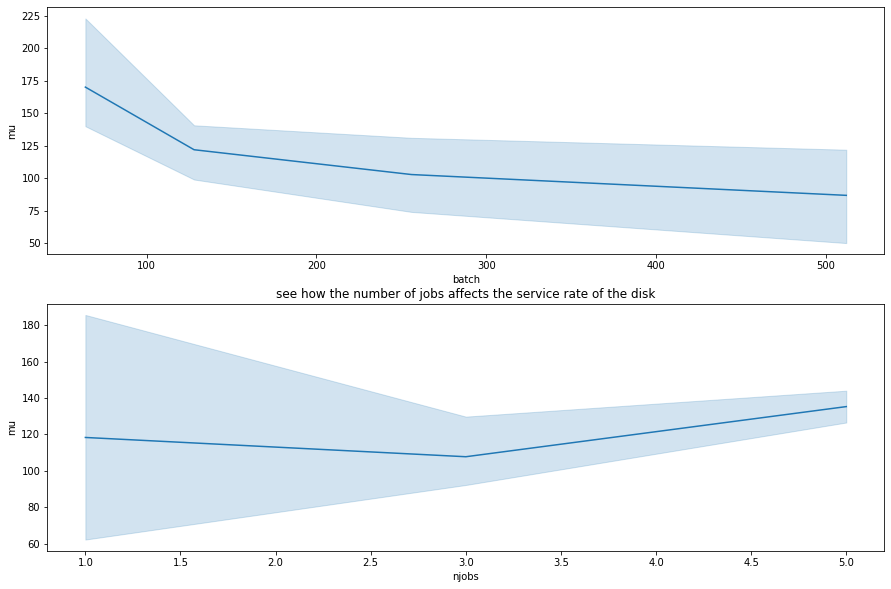

In [39]:
f, (ax1, ax2) = plt.subplots(2, figsize=(15, 10))

plt.title('see how the number of jobs affects the service rate of the disk')
sns.lineplot(x='batch', y='mu', data=df_mu, ax=ax1)
sns.lineplot(x='njobs', y='mu', data=df_mu, ax=ax2)

print('We see that the service rate stabilizes at around 125-130 rps')

In [91]:
# Try to fit a linear regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# print((X[:,0]**2).shape)
X = df_mu[['batch', 'njobs']].values
# print((X[:,0]**2).shape)
# X = np.hstack((X, (X[:,0]**2).reshape(-1,1), (X[:,1]**2).reshape(-1,1)))


l = LinearRegression()
l.fit(X, df_mu['mu'])

display(l.intercept_, l.coef_)

# so the best line of how it varies --> mu = -0.15 * batch + 4.23 * njobs + 145

# get the parameters

coef_batch, coef_jobs = l.coef_
intercept = l.intercept_


# mean_squared_error(y_pred, df_mu['mu'])


145.01710093681055

array([-0.15539907,  4.23819331])

In [92]:
def get_mu_disk(batch, jobs):
    return coef_batch * batch + coef_jobs * jobs  + intercept

# Take the mean of the mu as 120
print('Get the predictions of the response time based on the batch and number of jobs')
# Total time = Ncycles * (E(Tcpu) + E(t_disk)) 
Tcpu = 0.045
mu_cpu = 1/Tcpu

res = {
    'expected':[],
    'actual':[]
}

for (batch, njobs), row in serv_df.iterrows():
    # Measured time
    T_true = row.time
    
    # Apply the formula
    l_disk = njobs * mu_cpu
    mu_disk = get_mu_disk(batch, njobs)
    Nt = (num_examples/batch) * num_epochs
    Tdisk = 1/(mu_disk - l_disk)
    
    T = Nt * (Tcpu + Tdisk)
#     print(f'[Batch {batch}, Njobs {njobs}]--> Expected: {T}, Actual {T_true}')
    res['expected'].append(T)
    res['actual'].append(T_true)

    
res = pd.DataFrame(res)    
    
res
    

Get the predictions of the response time based on the batch and number of jobs


,expected,actual
0,501.943303,468.621367
1,537.445276,549.722318
2,629.509685,680.756922
3,254.687854,256.083148
4,276.797286,355.678648
5,344.082890,369.372507
6,132.330934,150.582501
7,151.171161,169.310548
8,258.507045,222.786779
9,77.421670,94.532546


## Run the ANOVA tests on this data 

We want to see how factors like number of CPUs, Jobs, and Batch influence all the others
- Accuracy
- E(T)
- CPU Usage
- IO Wait

In [81]:
def ANOVA(df: pd.DataFrame, y: str, use_all = False,verbose=False):
    """Run the ANOVA analysis with the cpu, batch and njobs columns for the 
    given output variable"""
    
    # If use all is true we use all the variables to check either accuracy and time
    # including also the iowait and the cpu to see what fully influences the stuff
    
    
    if not use_all:
        # Plot the summary dataframe
        if verbose:
            display(rp.summary_cont(results_df.groupby(['cpu', 'batch', 'njobs', 'network']))[y])

        model = ols(f'{y} ~ cpu*batch*njobs*C(network)', df).fit()
        
    else:
        if y not in ['final_accuracy', 'time']:
            raise ValueError('When use_all = True we predict either final_accuracy or time, not', y)
        if verbose:
            display(rp.summary_cont(results_df.groupby(['cpu', 'batch', 'njobs', 'cpu_mean', 'iowait_mean']))[y])

        model = ols(f'{y} ~ cpu*batch*njobs*cpu_mean*iowait_mean', df).fit()
        

    if verbose:
        print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
        display(model.summary())
    
    res = sm.stats.anova_lm(model, typ=2)
    
    return res, model

In [82]:
# Simply change the output value for the y to the variable that you want to study
# - iowait_mean
# - final_accuracy
# - time
# - cpu_mean
res, model = ANOVA(results_df, y='time', verbose=True)
res

c:\users\diego\cs\qpe\venv\lib\site-packages\scipy\stats\_distn_infrastructure.py:2016: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)


N      Mean  SD  SE  95% Conf.  Interval
cpu batch njobs network                                            
1   64    1     lenet      1  493.5107 NaN NaN        NaN       NaN
                simplenet  1  402.6886 NaN NaN        NaN       NaN
          3     lenet      1  512.4431 NaN NaN        NaN       NaN
                simplenet  1  431.7348 NaN NaN        NaN       NaN
          5     lenet      1  547.8436 NaN NaN        NaN       NaN
...                       ..       ...  ..  ..        ...       ...
8   512   1     simplenet  1   73.3851 NaN NaN        NaN       NaN
          3     lenet      1  105.8141 NaN NaN        NaN       NaN
                simplenet  1  107.3328 NaN NaN        NaN       NaN
          5     lenet      1  158.9105 NaN NaN        NaN       NaN
                simplenet  1  143.6727 NaN NaN        NaN       NaN

[96 rows x 6 columns]

Overall model F( 15, 80) =  12.742, p =  0.0000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     12.74
Date:                Wed, 21 Oct 2020   Prob (F-statistic):           1.70e-15
Time:                        19:11:52   Log-Likelihood:                -584.57
No. Observations:                  96   AIC:                             1201.
Df Residuals:                      80   BIC:                             1242.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                 443.4141    104.365      4.249      0.000     235.721     651.107
C(network)[T.simplenet]                   -40.8651    147.595     -0.277      0.783    -334.588     252.857
cpu                                       -17.0859     22.640     -0.755      0.453     -62.141      27.969
cpu:C(network)[T.simplenet]                 5.7266     32.018      0.179      0.859     -57.991      69.444
batch                                      -0.6528      0.354     -1.845      0.069      -1.357       0.051
batch:C(network)[T.simplenet]              -0.1769      0.500     -0.354      0.725      -1.172       0.819
cpu:batch                                   0.0111      0.077      0.144      0.886      -0.142       0.164
cpu:batch:C(network)[T.simplenet]           0.0223      0.109      0.206      0.838      -0.194       0.238
njobs                                      -7.9097     30.555     -0.259      0.796     -68.716      52.897
njobs:C(network)[T.simplenet]               6.4910     43.211      0.150      0.881     -79.502      92.484
cpu:njobs                                  14.1792      6.628      2.139      0.035       0.988      27.370
cpu:njobs:C(network)[T.simplenet]          -2.0246      9.374     -0.216      0.830     -20.679      16.630
batch:njobs                                 0.0341      0.104      0.329      0.743      -0.172       0.240
batch:njobs:C(network)[T.simplenet]         0.0207      0.146      0.141      0.888      -0.271       0.312
cpu:batch:njobs                            -0.0287      0.022     -1.278      0.205      -0.073       0.016
cpu:batch:njobs:C(network)[T.simplenet]    -0.0012      0.032     -0.038      0.970      -0.064       0.062
==============================================================================
Omnibus:                        5.415   Durbin-Watson:                   0.945
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                5.279
Skew:                           0.574   Prob(JB):                       0.0714
Kurtosis:                       2.973   Cond. No.                     8.28e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,sum_sq,df,F,PR(>F)
C(network),2.688175e+04,1.0,1.966283,1.647114e-01
cpu,6.234413e+04,1.0,4.560201,3.578200e-02
cpu:C(network),2.945205e+03,1.0,0.215429,6.438057e-01
batch,2.063200e+06,1.0,150.914109,4.209342e-20
batch:C(network),1.423624e+03,1.0,0.104132,7.477683e-01
cpu:batch,8.773398e+04,1.0,6.417359,1.325508e-02
cpu:batch:C(network),1.769050e+03,1.0,0.129398,7.200046e-01
njobs,2.151680e+05,1.0,15.738603,1.575780e-04
njobs:C(network),4.900597e+02,1.0,0.035846,8.503140e-01
cpu:njobs,6.915558e+04,1.0,5.058430,2.725570e-02


In [83]:
model.params

Intercept                                  443.414145
C(network)[T.simplenet]                    -40.865089
cpu                                        -17.085933
cpu:C(network)[T.simplenet]                  5.726567
batch                                       -0.652839
batch:C(network)[T.simplenet]               -0.176891
cpu:batch                                    0.011081
cpu:batch:C(network)[T.simplenet]            0.022306
njobs                                       -7.909685
njobs:C(network)[T.simplenet]                6.491036
cpu:njobs                                   14.179205
cpu:njobs:C(network)[T.simplenet]           -2.024639
batch:njobs                                  0.034105
batch:njobs:C(network)[T.simplenet]          0.020671
cpu:batch:njobs                             -0.028711
cpu:batch:njobs:C(network)[T.simplenet]     -0.001214
dtype: float64

In [85]:
test = results_df[['cpu', 'batch', 'njobs','network', 'time', 'final_accuracy']]
test = test[test.index > 50]
answers = test[['time']]
test = test[['cpu', 'batch', 'njobs','network']]

y = model.predict(test)
mean_squared_error(y, answers)

13300.007108211486

## Regress the datapoints we have to get an idea of the performance

In [ ]:
# We want to fit the response time based on the number of processes (cpu * jobs) and the batch size

# 1) Transform the dataset
df_regr = results_df[['cpu', 'batch', 'njobs','network', 'time', 'final_accuracy']]
df_regr['processes'] = df_regr['cpu'] * df_regr['njobs']
df_regr = df_regr[['processes', 'batch', 'network', 'time', 'final_accuracy']]

X_init = df_regr[['processes', 'batch', 'network']].reset_index(drop=True)
# Map the network to +-1
X_init['network'] = X_init['network'].apply(lambda net: 1 if net=='lenet' else -1)

# X = df_regr[['cpu','njobs', 'batch']].reset_index(drop=True)
y_time = df_regr['time'].reset_index(drop=True)
y_acc = df_regr['final_accuracy'].reset_index(drop=True)

scaler = StandardScaler()
X = scaler.fit_transform(X_init)
X

In [ ]:
# Scale the data

%matplotlib inline

# PLot the datapoints
from mpl_toolkits.mplot3d import Axes3D

# plot the train examples
f = plt.figure()
ax = Axes3D(f)
# print(xtrain.shape, y.ravel().shape)
# ax.scatter(xtrain[:,0], xtrain[:,1], y, c='r')

X2 = np.hstack((X, (X[:,0]*X[:,1]).reshape(-1,1), (X[:,0]*X[:,2]).reshape(-1,1), (X[:,1]*X[:,2]).reshape(-1,1), (X[:,0]*X[:,1]*X[:,2]).reshape(-1,1)))

# Fit a simple linear regression
regressors = [LinearRegression(), Lasso(alpha=1), Ridge(), DecisionTreeRegressor(max_depth=20), RandomForestRegressor(n_estimators=50, criterion='mae', max_depth=4)]

# Try with second order stats

# xtrain_2 = np.concatenate((xtrain, xtrain**2, xtrain**3), axis =1)
# print(xtrain_2)

for r in regressors:
    loo = LeaveOneOut()

    scores = cross_validate(r, X2, y_acc, cv=10, scoring='neg_mean_squared_error')

    print(r,np.mean(scores['test_score']))


x1,x2 = np.meshgrid(np.linspace(-2,2), np.linspace(-2,2))

lr = regressors[0].fit(X, y_time)
inter = lr.intercept_
coefs = lr.coef_

y_out = coefs[0]*x1+coefs[1]*x2 + inter
print(inter, coefs)
ax.plot_wireframe(x1,x2,y_out);

In [ ]:
(X[:,0]*X[:,1]).reshape(-1,1).shape

In [31]:
# Fit just the Random Forest regressor with a GridSearch crossval to find the best hyperparams

from sklearn.model_selection import GridSearchCV, train_test_split

x_train, x_test, y_train_acc, y_test_acc = train_test_split(X, y_acc, test_size=0.2, random_state = 42)
x_train, x_test, y_train_time, y_test_time = train_test_split(X, y_time, test_size=0.2, random_state = 42)

reg_acc = RandomForestRegressor(random_state=42)
reg_time = RandomForestRegressor(random_state=42)

params_rf = {
    'n_estimators': [50, 100, 150, 200, 500,1000, 2000],
    'max_features': ['auto', 'log2', 'sqrt'],
    'max_depth': range(4,10),
    'criterion': ['mse', 'mae']
    
}

# First cross validation
print('Fitting the time...')
cv_time = GridSearchCV(estimator=reg_time, param_grid=params_rf, n_jobs=8, cv=5, verbose=3)
cv_time.fit(x_train, y_train_time)


# Second cross val
print('Fitting the accuracy')
cv_acc = GridSearchCV(estimator=reg_acc, param_grid=params_rf, n_jobs=8, cv=5, verbose=3)
cv_acc.fit(x_train, y_train_acc)

c:\users\diego\cs\qpe\venv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


array([[-0.93045745, -1.02575529,  1.        ],
       [-0.83968112, -1.02575529,  1.        ],
       [-0.65812844,  0.09325048,  1.        ],
       [-0.2950231 ,  0.09325048,  1.        ],
       [-0.93045745,  1.58525817,  1.        ],
       [-0.83968112,  1.58525817,  1.        ],
       [-0.65812844,  1.58525817,  1.        ],
       [-0.2950231 ,  1.58525817,  1.        ],
       [-0.74890478, -1.02575529,  1.        ],
       [-0.47657577, -1.02575529,  1.        ],
       [ 0.06808225, -1.02575529,  1.        ],
       [ 1.1573983 , -1.02575529,  1.        ],
       [-0.65812844, -1.02575529,  1.        ],
       [-0.74890478, -0.65275337,  1.        ],
       [-0.47657577, -0.65275337,  1.        ],
       [ 0.06808225, -0.65275337,  1.        ],
       [ 1.1573983 , -0.65275337,  1.        ],
       [-0.74890478,  0.09325048,  1.        ],
       [-0.47657577,  0.09325048,  1.        ],
       [ 0.06808225,  0.09325048,  1.        ],
       [ 1.1573983 ,  0.09325048,  1.   

LinearRegression() -2.1074726777581722e-05
Lasso(alpha=1) -0.0004350320289721093
Ridge() -2.1321564610011425e-05
DecisionTreeRegressor(max_depth=20) -2.0876511111111105e-05
RandomForestRegressor(criterion='mae', max_depth=4, n_estimators=50) -1.3479058364444307e-05
298.72329023590623 [  55.58951826 -146.60037323   16.7337462 ]


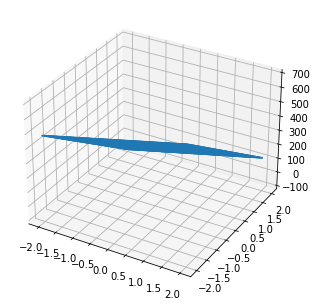

In [111]:
# Scale the data

%matplotlib inline

# PLot the datapoints
from mpl_toolkits.mplot3d import Axes3D

# plot the train examples
f = plt.figure()
ax = Axes3D(f)
# print(xtrain.shape, y.ravel().shape)
# ax.scatter(xtrain[:,0], xtrain[:,1], y, c='r')

X2 = np.hstack((X, (X[:,0]*X[:,1]).reshape(-1,1), (X[:,0]*X[:,2]).reshape(-1,1), (X[:,1]*X[:,2]).reshape(-1,1), (X[:,0]*X[:,1]*X[:,2]).reshape(-1,1)))

# Fit a simple linear regression
regressors = [LinearRegression(), Lasso(alpha=1), Ridge(), DecisionTreeRegressor(max_depth=20), RandomForestRegressor(n_estimators=50, criterion='mae', max_depth=4)]

# Try with second order stats

# xtrain_2 = np.concatenate((xtrain, xtrain**2, xtrain**3), axis =1)
# print(xtrain_2)

for r in regressors:
    loo = LeaveOneOut()

    scores = cross_validate(r, X2, y_acc, cv=10, scoring='neg_mean_squared_error')

    print(r,np.mean(scores['test_score']))


x1,x2 = np.meshgrid(np.linspace(-2,2), np.linspace(-2,2))

lr = regressors[0].fit(X, y_time)
inter = lr.intercept_
coefs = lr.coef_

y_out = coefs[0]*x1+coefs[1]*x2 + inter
print(inter, coefs)
ax.plot_wireframe(x1,x2,y_out);

In [106]:
(X[:,0]*X[:,1]).reshape(-1,1).shape

(96, 1)

In [32]:
# Fit just the Random Forest regressor with a GridSearch crossval to find the best hyperparams

from sklearn.model_selection import GridSearchCV, train_test_split

x_train, x_test, y_train_acc, y_test_acc = train_test_split(X, y_acc, test_size=0.2, random_state = 42)
x_train, x_test, y_train_time, y_test_time = train_test_split(X, y_time, test_size=0.2, random_state = 42)

reg_acc = RandomForestRegressor(random_state=42)
reg_time = RandomForestRegressor(random_state=42)

params_rf = {
    'n_estimators': [50, 100, 150, 200, 500,1000, 2000],
    'max_features': ['auto', 'log2', 'sqrt'],
    'max_depth': range(4,10),
    'criterion': ['mse', 'mae']
    
}

# First cross validation
print('Fitting the time...')
cv_time = GridSearchCV(estimator=reg_time, param_grid=params_rf, n_jobs=8, cv=5, verbose=3)
cv_time.fit(x_train, y_train_time)


# Second cross val
print('Fitting the accuracy')
cv_acc = GridSearchCV(estimator=reg_acc, param_grid=params_rf, n_jobs=8, cv=5, verbose=3)
cv_acc.fit(x_train, y_train_acc)

Fitting the time...
Fitting 5 folds for each of 252 candidates, totalling 1260 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   12.2s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   30.6s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:   58.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done 1260 out of 1260 | elapsed:  3.2min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting the accuracy
Fitting 5 folds for each of 252 candidates, totalling 1260 fits


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 136 tasks      | elapsed:   17.4s
[Parallel(n_jobs=8)]: Done 296 tasks      | elapsed:   37.9s
[Parallel(n_jobs=8)]: Done 520 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 808 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 1160 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done 1260 out of 1260 | elapsed:  3.1min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=8,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': range(4, 10),
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'n_estimators': [50, 100, 150, 200, 500, 1000, 2000]},
             verbose=3)

In [33]:
cv_time.best_params_

{'criterion': 'mae',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 50}

In [34]:
cv_acc.best_params_

{'criterion': 'mse',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 50}

### Fit the regressors on the accuracy and time

In [36]:
from sklearn.metrics import mean_squared_error

# 1) Fit on the time
r_t = cv_time.best_estimator_.fit(x_train, y_train_time)

# test the performance on the train and the test set
y_pred = r_t.predict(x_test)

err = mean_squared_error(y_pred, y_test_time)

print('Mean Squared Error with the test set is for TIME', err)


# 2) Fit on the acc
r_acc = cv_acc.best_estimator_.fit(x_train, y_train_acc)

# test the performance on the train and the test set
y_pred = r_acc.predict(x_test)
err = mean_squared_error(y_pred, y_test_acc)

print('Mean Squared Error with the test set is for ACCURACY', err)

Mean Squared Error with the test set is for TIME 1597.7368579880053
Mean Squared Error with the test set is for ACCURACY 1.8683460366070817e-05


In [ ]:
# Run some examples with it

## Create the Final Optimizer that will multiplex the regressors seen above

In [42]:
# Import the 3 regressors
from sklearn.tree import  DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, LeaveOneOut, cross_validate


from typing import Tuple, Optional
# Declare the class for the ML model

from dataclasses import dataclass

@dataclass
class Job:
    cpu:int
    njobs: int
    network: int


class Courier:
    """ Courier has 3 parameters to account for utilization, accuracy and response time,
    based on which, and their weights, it chooses the optimal batch size for the task

    labels are in format dict
    accuracy -> labels
    time -> labels
    utilization -> labels
    """

    def __init__(self, alpha: float, beta: float,
                models: dict, scaler, batches=[64,128,256,512]):


        self.batches = np.array(batches).reshape(len(batches), 1)
        

        if alpha + beta !=1:
            raise ValueError('The hyperparameters need to add up to 1')

        # Configure the hyperparams and the training data
        self.alpha = alpha
        self.beta = beta
        
        
        self.scaler = scaler

        # Compute the predictors
        self.acc_model = models['accuracy']
        self.time_model = models['time']

    def optimize(self, job: Job, latency = None):
        acc, t = self._predict(job)
        
        b = self.batches


        if latency:
            # Just take the options that satisfy the requirements
            fit = t[t<latency]
            if len(fit) == 0:
                print('Not a single value fulfills the '
                      'time requirements, selecting minimum time')
                # Return the minimum time
                min_t_idx = np.where(t == t.min())[0][0]
                return self.batches[min_t_idx], (acc[min_t_idx],
                                                 t[min_t_idx])

            else:
                acc = acc[t<latency]
                b = self.batches[t<latency]
                t = t[t<latency]


        # Return the batch that better fulfills the requirements and
        # also return a tuple with the predictions
        sc_a = acc/np.max(acc)
        sc_t = 1-( t/np.max(t))

        sc = self.alpha * sc_a + self.beta * sc_t

        # Get the index of the max score
        max_sc_idx = np.where(sc == sc.max())[0][0]
        return  b[max_sc_idx], (acc[max_sc_idx],
                                           t[max_sc_idx])



    def _fit_model(self, labels):
        """Fit the model to particular labels"""
        reg = self.model
        reg.fit(self.X, labels)
        return reg


    def _preprocess_data(self, X):
        """Standardizes the data"""
        scaler = StandardScaler()
        return scaler.fit_transform(X)

    def _predict(self, job: Job):
        """Predicts the time, accuracy and util with different batches
        and returns the best one given the optims"""

        acc = []
        t = []
        
        # predict the performance of the job with different batches
        for b in self.batches:
            data_point = self.scaler.transform([[job.cpu * job.njobs, b, job.network]])
            _acc = self.acc_model.predict(data_point)
            _t = self.time_model.predict(data_point)
            print(f'Batch {b}, acc = {_acc} and t = {_t}')

            acc.append(_acc)
            t.append(_t)


        return np.array(acc), np.array(t)




In [46]:
# Create the Courier

c = Courier(alpha = 0.98, beta=0.02, 
            models= {
                'accuracy': r_acc,
                'time': r_t
},
           scaler=scaler)

In [47]:
# Get some predidctions from the Courier

j = Job(cpu = 10, njobs=8, network=-1)
batch, prediction = c.optimize(j, latency=400)

print(f'Recommended batch {batch}, predictions {prediction}')

Batch [64], acc = [0.94840507] and t = [914.11793623]
Batch [128], acc = [0.93838265] and t = [409.66707557]
Batch [256], acc = [0.92522572] and t = [181.82810604]
Batch [512], acc = [0.91284016] and t = [127.20340717]
Recommended batch 256, predictions (0.9252257197159567, 181.82810603513997)


## Run the ANOVA test with all of the results


In [ ]:



# Get the last accuracy instead of the list for the accuracy of each of the experiments

df = pd.DataFrame(res_final)

df